In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import math
import cv2
import sys
import glob
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd.variable import Variable
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import LambdaLR
from PIL import Image
from tqdm import tqdm

In [3]:
!cp -r /content/drive/Shareddrives/AML_Project/data/test_X ./test_A
!cp -r /content/drive/Shareddrives/AML_Project/data/test_Y ./test_B

In [4]:
 class CustomDataset(Dataset):
    def __init__(self,pathsA, pathsB):
        self.pathsA = pathsA
        self.pathsB = pathsB   
        self.transforms = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
     
    def __getitem__(self, index):
        imageA = Image.open(self.pathsA[index%len(self.pathsA)])
        imageA = imageA.resize((256,256),Image.LANCZOS)
        t_imageA = self.transforms(imageA)
        
        imageB = Image.open(self.pathsB[index%len(self.pathsB)])
        imageB = imageB.resize((256,256),Image.LANCZOS)
        #print(imageB.size)
        t_imageB = self.transforms(imageB)
        return t_imageA, t_imageB

    def __len__(self):
        
        return max(len(self.pathsA),len(self.pathsB))

In [5]:
path_testA = glob.glob("./test_A/*.png")
path_testB = glob.glob("./test_B/*.jpg")

In [6]:
dataset_test = CustomDataset(path_testA,path_testB)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        self.model = nn.Sequential(
        
                    nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True),
                 
                    nn.Conv2d(512, 1, 4, padding=1) )

        

        
    def forward(self, x):
    
        x =  self.model(x)
        x = F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
        return x

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels) )

    def forward(self, x):
        return x + self.residual_block(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(3, 64, 7),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

                       nn.Conv2d(64, 128, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(128, 256, 3, stride=2, padding=1),
                       nn.InstanceNorm2d(256),
                       nn.ReLU(inplace=True),

                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),
                       ResidualBlock(256),

            
                       nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(128),
                       nn.ReLU(inplace=True),
                       nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                       nn.InstanceNorm2d(64),
                       nn.ReLU(inplace=True),

            
                       nn.ReflectionPad2d(3),
                       nn.Conv2d(64, 3, 7),
                       nn.Tanh()  )   

    def forward(self, x):
        return self.main(x)

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [25]:
GP = Generator()

checkpoint = torch.load("/content/drive/Shareddrives/AML_Project/new_models/lambda_5/CycleGAN_epoch-50.pth",map_location=torch.device('cpu'))
GP.load_state_dict(checkpoint['GA_state_dict'])

GP.eval()

Generator(
  (main): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (residual_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
      

In [26]:
GB = Generator()

checkpoint = torch.load("/content/drive/Shareddrives/AML_Project/new_models/baseline/CycleGAN_epoch-50.pth",map_location=torch.device('cpu'))
GB.load_state_dict(checkpoint['GA_state_dict'])

GB.eval()

Generator(
  (main): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (residual_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
      

In [16]:
dataset_test[0][0].shape

torch.Size([3, 256, 256])

In [17]:
pb.shape

torch.Size([3, 256, 256])

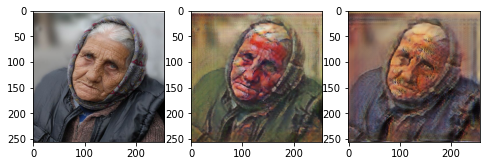

In [27]:
pb = GB(dataset_test[0][0])
pp = GP(dataset_test[0][0])
show_images = [dataset_test[0][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

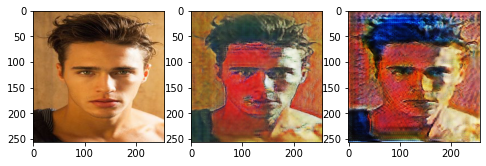

In [28]:
pb = GB(dataset_test[1][0])
pp = GP(dataset_test[1][0])
show_images = [dataset_test[1][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

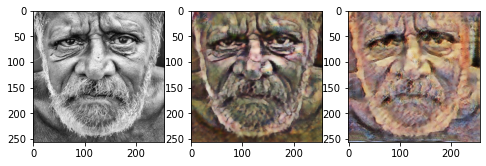

In [29]:
pb = GB(dataset_test[2][0])
pp = GP(dataset_test[2][0])
show_images = [dataset_test[2][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

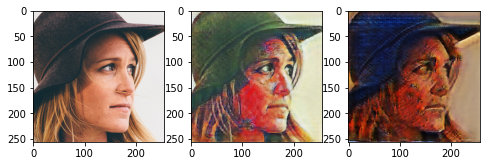

In [30]:
pb = GB(dataset_test[3][0])
pp = GP(dataset_test[3][0])
show_images = [dataset_test[3][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

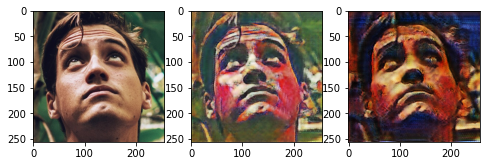

In [31]:
pb = GB(dataset_test[4][0])
pp = GP(dataset_test[4][0])
show_images = [dataset_test[4][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

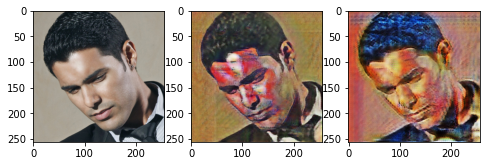

In [33]:
pb = GB(dataset_test[5][0])
pp = GP(dataset_test[5][0])
show_images = [dataset_test[5][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

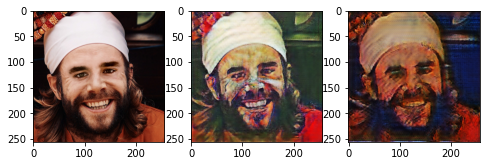

In [34]:
pb = GB(dataset_test[6][0])
pp = GP(dataset_test[6][0])
show_images = [dataset_test[6][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

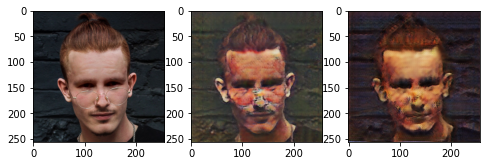

In [35]:
pb = GB(dataset_test[7][0])
pp = GP(dataset_test[7][0])
show_images = [dataset_test[7][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

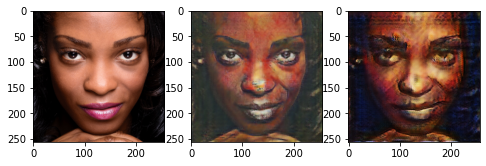

In [36]:
pb = GB(dataset_test[8][0])
pp = GP(dataset_test[8][0])
show_images = [dataset_test[8][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

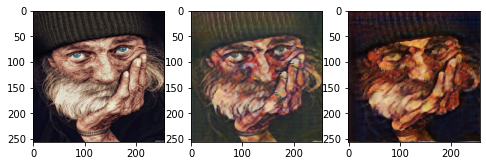

In [37]:
pb = GB(dataset_test[9][0])
pp = GP(dataset_test[9][0])
show_images = [dataset_test[9][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

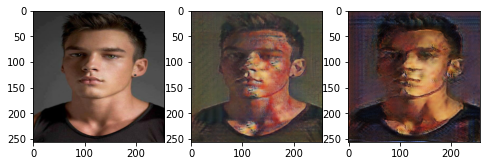

In [38]:
pb = GB(dataset_test[10][0])
pp = GP(dataset_test[10][0])
show_images = [dataset_test[10][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

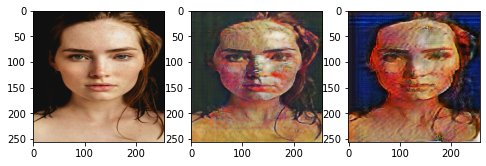

In [39]:
pb = GB(dataset_test[11][0])
pp = GP(dataset_test[11][0])
show_images = [dataset_test[11][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

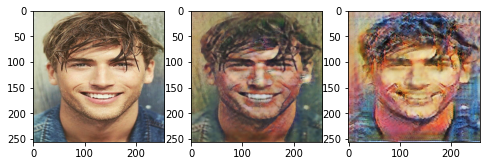

In [40]:
pb = GB(dataset_test[12][0])
pp = GP(dataset_test[12][0])
show_images = [dataset_test[12][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

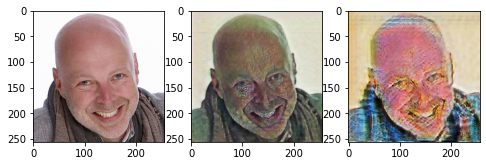

In [41]:
pb = GB(dataset_test[13][0])
pp = GP(dataset_test[13][0])
show_images = [dataset_test[13][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

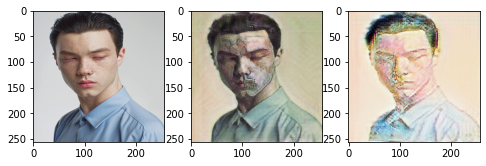

In [42]:
pb = GB(dataset_test[14][0])
pp = GP(dataset_test[14][0])
show_images = [dataset_test[14][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

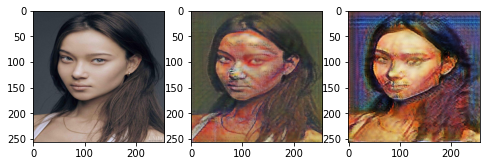

In [43]:
pb = GB(dataset_test[15][0])
pp = GP(dataset_test[15][0])
show_images = [dataset_test[15][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

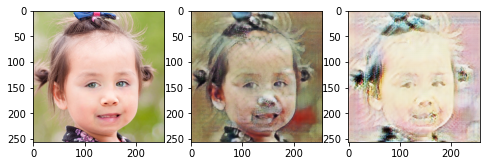

In [44]:
pb = GB(dataset_test[16][0])
pp = GP(dataset_test[16][0])
show_images = [dataset_test[16][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

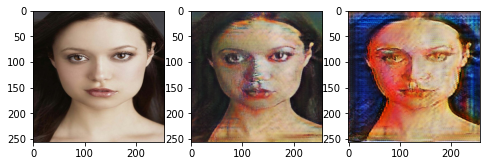

In [45]:
pb = GB(dataset_test[17][0])
pp = GP(dataset_test[17][0])
show_images = [dataset_test[17][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

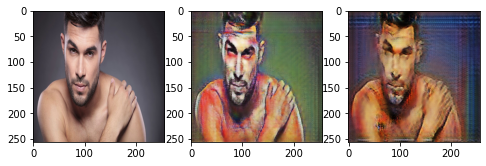

In [46]:
pb = GB(dataset_test[18][0])
pp = GP(dataset_test[18][0])
show_images = [dataset_test[18][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

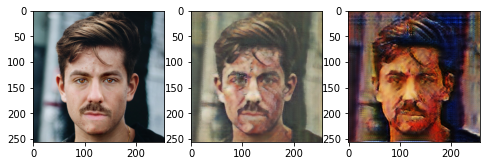

In [47]:
pb = GB(dataset_test[19][0])
pp = GP(dataset_test[19][0])
show_images = [dataset_test[19][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()

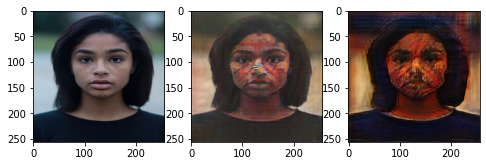

In [48]:
pb = GB(dataset_test[20][0])
pp = GP(dataset_test[20][0])
show_images = [dataset_test[20][0].detach(),pb.detach(),pp.detach()]
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
for i in range(1, columns*rows+1):
  img = show_images[i-1].permute(1,2,0)
  fig.add_subplot(rows, columns, i)
  plt.imshow((img+1.)/2.)
plt.show()